# Introduction to the ```spline_density``` library

In [1]:
from spline_density import Spline, SplineDistribution
from spline_density import MLE_density, score_matching, generalized_score_matching
from spline_density import kfold_crossvalidation, simple_validation

import matplotlib.pyplot as plt
import numpy as np
import numbers

# Define random number generator for reproducibility
rng = np.random.default_rng(42)

In [2]:
# Define function to sample from a density via acceptance-rejection method

def sample_from_density(f, a, b, size, num_grid=1000, rng=None):
    if rng is None or isinstance(rng, numbers.Integral):
        rng = np.random.default_rng(rng)
    elif not isinstance(rng, np.random.Generator):
        raise TypeError("`rng` must be None, an integer, or a numpy.random.Generator.")
    
    M = np.max(f(np.linspace(a, b, num_grid))) * 1.05
    
    sample = np.zeros(size, dtype=float)
    i = 0
    while i < size:
        X = rng.uniform(a, b)
        U = rng.uniform(0, 1)
        if U*M <= f(X):
            sample[i] = X
            i += 1
    return sample

In [3]:
# Define basic parameters and two densities

degree = 3
q = 2
n = 1000
k = 10
a, b = -2, 2

f1 = lambda x: np.exp(-(x-2)**4) + 0.5*np.exp(-(x+2)**4) + 0.05
f2 = lambda x: (
    np.exp(-np.sqrt(16*(x - 0.5)**2 + 1))
    + 2*np.exp(-np.sqrt(16*(x + 0.5)**2 + 1))
    + 4*np.exp(-np.sqrt(128*(x - 1.25)**2 + 1))
) * (4 - x**2)

In [4]:
# Sample from densities

sample1 = sample_from_density(f1, a, b, n, rng=rng)
sample2 = sample_from_density(f2, a, b, n, rng=rng)

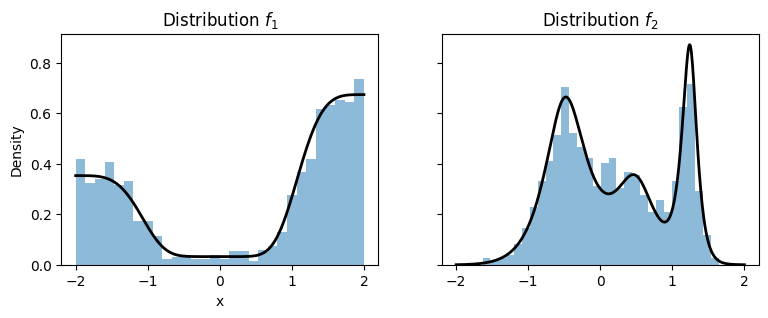

In [5]:
# Plot histograms of the samples vs densities

xx = np.linspace(a, b, 1000)

fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axes = axes.flatten()

axes[0].hist(sample1, bins=30, density=True, alpha=0.5)
axes[1].hist(sample2, bins=30, density=True, alpha=0.5)

axes[0].plot(xx, f1(xx) / np.trapz(f1(xx), xx), linewidth=2, color="black")
axes[1].plot(xx, f2(xx) / np.trapz(f2(xx), xx), linewidth=2, color="black")

axes[0].set_title("Distribution $f_1$")
axes[1].set_title("Distribution $f_2$")

axes[0].set_xlabel("x")
axes[0].set_xlabel("x")
axes[0].set_ylabel("Density")

plt.show()

In [6]:
# Estimate the densities using the methods provided in the spline_density library

distr_MLE = MLE_density(
    sample=sample1,
    L=a,
    U=b,
    degree=degree,
    k=k,
    q=q,
    lambda_n=1e-4,
)

distr_shifted_MLE = MLE_density(
    sample=sample2,
    L=a,
    U=b,
    degree=degree,
    k=k,
    q=q,
    lambda_n=1e-5,
    gamma=0.05
)

distr_SM = score_matching(
    sample=sample2,
    L=a,
    U=b,
    degree=degree,
    k=k,
    q=q,
    lambda_n=1e-5
)

distr_shifted_SM = score_matching(
    sample=sample2,
    L=a,
    U=b,
    degree=degree,
    k=k,
    q=q,
    lambda_n=1e-6,
    gamma=0.05
)

distr_gen_SM = generalized_score_matching(
    sample=sample1,
    L=a,
    U=b,
    degree=degree,
    k=k,
    q=q,
    lambda_n=1e-4
)

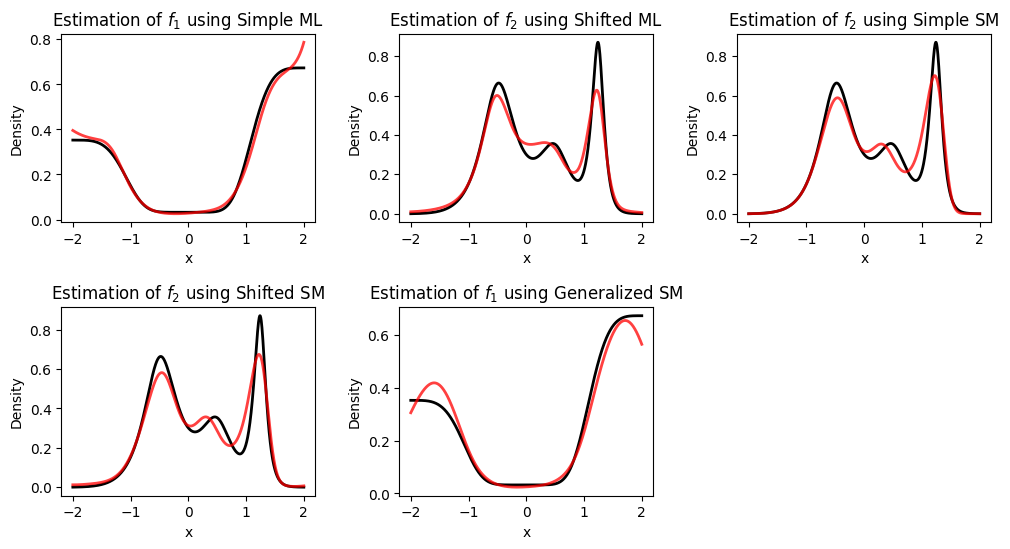

In [7]:
# Plot the estimated densities vs actual densities

distrs = [distr_MLE, distr_shifted_MLE, distr_SM, distr_shifted_SM, distr_gen_SM]
fs = [f1, f2, f2, f2, f1]
titles = ["Estimation of $f_1$ using Simple ML", "Estimation of $f_2$ using Shifted ML", "Estimation of $f_2$ using Simple SM", 
              "Estimation of $f_2$ using Shifted SM", "Estimation of $f_1$ using Generalized SM"]

xx = np.linspace(a, b, 1000)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    f = fs[i]
    distr = distrs[i]
    title = titles[i]
    
    ax.plot(xx, f(xx) / np.trapz(f(xx), xx), linewidth=2, color="black")
    ax.plot(xx, distr.pdf(xx), linewidth=2, color="red", alpha=0.75)
    
    ax.set_title(title)
    
    ax.set_xlabel("x")
    ax.set_ylabel("Density")

fig.delaxes(axes[5])
fig.subplots_adjust(wspace=0.33, hspace=0.45)
plt.show()

In [8]:
# Estimate f_1 using MLE_density by choosing \lambda_n via 5-fold cross-validation

distr1, stats = kfold_crossvalidation(
    MLE_density,
    sample=sample1,
    L=a,
    U=b,
    degree=degree,
    k=k,
    q=q,
    n_folds = 5,
    verbose=True,
    output_stats = True,
    rng=rng
)

print("\nStats:")
for key in sorted(stats):
    print(f"    {key}: {stats[key]}")

Completed 2/45 (4.44%)
Completed 4/45 (8.89%)
Completed 6/45 (13.33%)
Completed 8/45 (17.78%)
Completed 10/45 (22.22%)
Completed 12/45 (26.67%)
Completed 14/45 (31.11%)
Completed 16/45 (35.56%)
Completed 18/45 (40.00%)
Completed 20/45 (44.44%)
Completed 22/45 (48.89%)
Completed 24/45 (53.33%)
Completed 26/45 (57.78%)
Completed 28/45 (62.22%)
Completed 30/45 (66.67%)
Completed 32/45 (71.11%)
Completed 34/45 (75.56%)
Completed 36/45 (80.00%)
Completed 38/45 (84.44%)
Completed 40/45 (88.89%)
Completed 42/45 (93.33%)
Completed 44/45 (97.78%)
Completed 45/45 (100.00%)

Selected lambda_n: 0.0001

Stats:
    best_lambda: 0.0001
    converged: True
    cv_scores: [1.26508622 1.09336652 1.01559485 0.98076193 0.97684728 0.97692873
 0.97743801 0.97756512 0.97757948]
    ell: -0.9717547902976572
    iterations: 78
    lambda_vector: [1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08]
    last_eps: 1.1945999744966684e-13
    n_folds: 5
    old_ell: -0.9717547902975378


In [9]:
# Estimate f_2 using (shifted) score_matching by choosing \lambda_n via simple validation with test ratio of 20%

distr2, stats = simple_validation(
    score_matching,
    sample=sample2,
    L=a,
    U=b,
    degree=degree,
    k=k,
    q=q,
    test_ratio = 0.2,
    verbose=True,
    output_stats = True,
    rng=rng,
    gamma=0.05
)

print("\nStats:")
for key in sorted(stats):
    print(f"    {key}: {stats[key]}")

Completed 1/9 (11.11%)
Completed 2/9 (22.22%)
Completed 3/9 (33.33%)
Completed 4/9 (44.44%)
Completed 5/9 (55.56%)
Completed 6/9 (66.67%)
Completed 7/9 (77.78%)
Completed 8/9 (88.89%)
Completed 9/9 (100.00%)

Selected lambda_n: 1e-06

Stats:
    best_lambda: 1e-06
    converged: True
    cv_scores: [1.13556614 1.12461166 1.07248049 1.00324546 0.97263283 0.96366108
 0.96347554 0.96399778 0.96432376]
    ell: 4.207151587677848
    iterations: 118
    lambda_vector: [1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08]
    last_eps: 2.7934284288353853e-12
    old_ell: 4.207151587689601
    test_ratio: 0.2


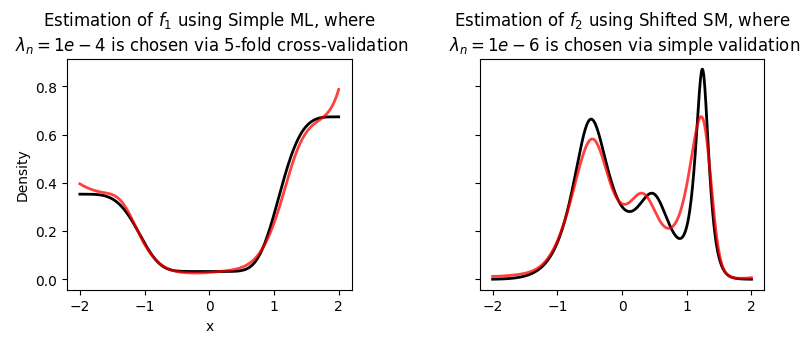

In [10]:
# Plot the estimated densities vs actual densities

xx = np.linspace(a, b, 1000)

fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axes = axes.flatten()

axes[0].plot(xx, f1(xx) / np.trapz(f1(xx), xx), linewidth=2, color="black")
axes[1].plot(xx, f2(xx) / np.trapz(f2(xx), xx), linewidth=2, color="black")

axes[0].plot(xx, distr1.pdf(xx), linewidth=2, color="red", alpha=0.75)
axes[1].plot(xx, distr2.pdf(xx), linewidth=2, color="red", alpha=0.75)

axes[0].set_title("Estimation of $f_1$ using Simple ML, where\n $\\lambda_n=1e-4$ is chosen via 5-fold cross-validation")
axes[1].set_title("Estimation of $f_2$ using Shifted SM, where\n $\\lambda_n=1e-6$ is chosen via simple validation")

axes[0].set_xlabel("x")
axes[0].set_xlabel("x")
axes[0].set_ylabel("Density")

fig.subplots_adjust(wspace=0.45)

plt.show()